In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph


import numpy as np
from scipy.optimize import minimize
from collections import defaultdict
from typing import Sequence
from scipy.optimize import minimize


from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import circuit_drawer

from qiskit_aer import AerSimulator

from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Sampler

In [14]:
n = 5

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [
    (0, 1, 1.0),
    (0, 2, 1.0),
    (0, 4, 1.0),
    (1, 2, 1.0),
    (2, 3, 1.0),
    (3, 4, 1.0),
]
graph.add_edges_from(edge_list)

# draw_gragh(graph, node_size=600, label=True)
# plt.show()

def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str,float]]:

    pauli_list = []
    for edge in list(graph.edge_list()):
        weight = graph.get_edge_data(edge[0], edge[1])
        pauli_list.append(('ZZ', [edge[0], edge[1]], weight))
    return pauli_list

max_cut_pauli_list = build_max_cut_paulis(graph)
cost_func_h = SparsePauliOp.from_sparse_list(max_cut_pauli_list, n)
# print("my hamiltonian cost function:",cost_func_h )

circuit = QAOAAnsatz(cost_operator= cost_func_h, reps= 2)
circuit.measure_all()
# print(circuit)
# print(circuit.parameters)


In [15]:
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    pauli_list = []
    for edge in list(graph.edge_list()):
        weight = graph.get_edge_data(edge[0], edge[1])
        pauli_list.append(("ZZ", [edge[0], edge[1]], weight))
    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, n)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


In [16]:

QiskitRuntimeService.save_account(
    channel="ibm_cloud",
    token="_2MSnezH80RhuEzSv9DiQOqywg1lduEnPjvU2LnFHNjR",
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/548688c615f4437690f2bf64246364a3:40dc2cd8-3067-4b8c-8485-e6169858d8d3::",
    overwrite= True
)


In [17]:
service = QiskitRuntimeService(channel= "ibm_cloud")
backend = service.least_busy(operational = True, simulator = False, min_num_qubits= 127)
print(backend)

<IBMBackend('ibm_fez')>


In [18]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

candidate_circuit = pm.run(circuit)
print(candidate_circuit.draw(output="text", fold=-1))

ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (/usr/local/lib/python3.12/dist-packages/qiskit/providers/__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (/usr/local/lib/python3.12/dist-packages/qiskit/providers/__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (/usr/local/lib/python3.12/dist-packages/qiskit/providers/__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (/usr/local/lib/python3.12/dist-packages/qiskit/providers/__init__.py)


global phase: 5π/4
                                                                                                            ┌─────────┐┌────┐┌───────┐┌────────────┐┌────┐┌───────┐                                    ┌────┐  ┌───────┐┌────────────┐    ┌────┐    ┌──────────┐               ┌────┐  ┌─────────┐                                                                                                                               ┌────┐   ┌────┐                                                                                                                                                                                                                             ┌─────────┐   ┌────┐  ┌────────────────┐┌────┐┌──────────┐                                                                                                                                                                                                                                                                              

In [19]:
initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_beta, initial_beta, initial_gamma, initial_gamma]

In [20]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)

    return cost

In [24]:

backend = AerSimulator()

objective_func_vals = []

estimator = Estimator(backend)
estimator.options.default_shots = 100


result = minimize(
    cost_func_estimator,
    init_params,
    args=(candidate_circuit, cost_hamiltonian, estimator),
    method="COBYLA",
    tol=1e-2,
    options={'maxiter': 5},
)

print(result)



 message: Return from COBYLA because the objective function has been evaluated MAXFUN times.
 success: False
  status: 3
     fun: -0.38
       x: [ 2.571e+00  1.571e+00  3.142e+00  3.142e+00]
    nfev: 6
   maxcv: 0.0


/usr/local/lib/python3.12/dist-packages/scipy/_lib/pyprima/common/preproc.py:68: UserWarning: COBYLA: Invalid MAXFUN; it should be at least num_vars + 2; it is set to 6
  warn(f'{solver}: Invalid MAXFUN; it should be at least {min_maxfun_str}; it is set to {maxfun}')


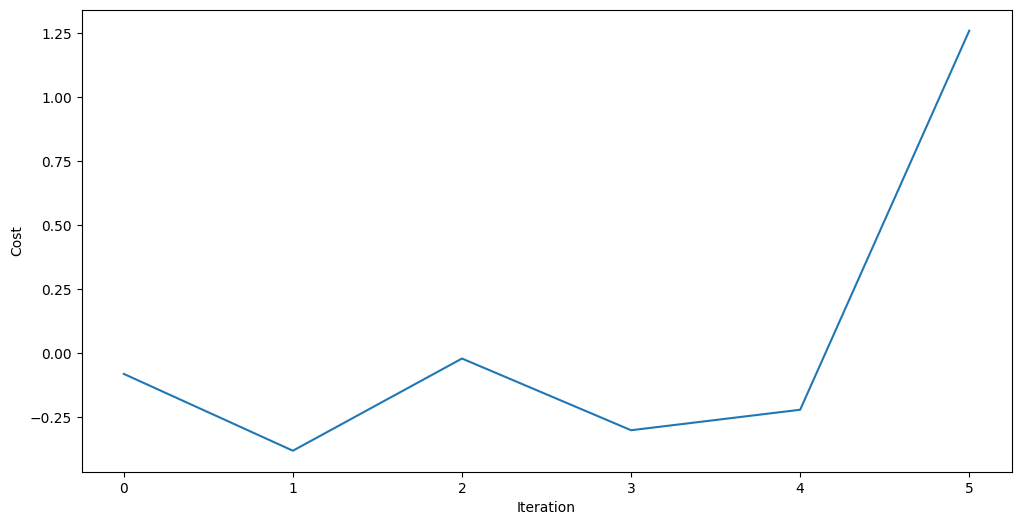

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [27]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
print(optimized_circuit)

global phase: 5π/4
                                                                             »
 q_2 -> 2 ───────────────────────────────────────────────────────────────────»
          ┌─────────┐┌────┐┌─────────┐                                       »
 q_0 -> 3 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─■─────────────────────────────────────»
          └─────────┘└────┘└─────────┘ │                                     »
 q_3 -> 4 ─────────────────────────────┼─────────────────────────────────────»
                                       │ ┌─────────┐┌────┐┌───────┐┌────────┐»
q_1 -> 16 ─────────────────────────────■─┤ Rz(π/2) ├┤ √X ├┤ Rz(π) ├┤ Rz(2π) ├»
                                         └─────────┘└────┘└───────┘└────────┘»
q_4 -> 23 ───────────────────────────────────────────────────────────────────»
                                                                             »
  meas: 5/═══════════════════════════════════════════════════════════════════»
                                 

In [33]:
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub = (optimized_circuit,)
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val / shots for key, val in counts_int.items()}
final_distribution_bin = {key: val / shots for key, val in counts_bin.items()}
print(final_distribution_int)

{7: 0.0282, 15: 0.0313, 4: 0.0309, 18: 0.0314, 23: 0.0296, 19: 0.0333, 8: 0.0303, 14: 0.0337, 24: 0.0307, 11: 0.0316, 25: 0.0296, 30: 0.0307, 17: 0.0317, 16: 0.0314, 28: 0.0315, 29: 0.0328, 9: 0.03, 10: 0.0301, 2: 0.034, 13: 0.0314, 6: 0.0305, 0: 0.0299, 22: 0.0354, 27: 0.0283, 5: 0.0327, 20: 0.034, 1: 0.0316, 31: 0.0324, 21: 0.0306, 12: 0.0296, 3: 0.0305, 26: 0.0303}


/usr/local/lib/python3.12/dist-packages/qiskit_ibm_runtime/fake_provider/local_service.py:273: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [34]:
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]


keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 1, 1, 0, 1]


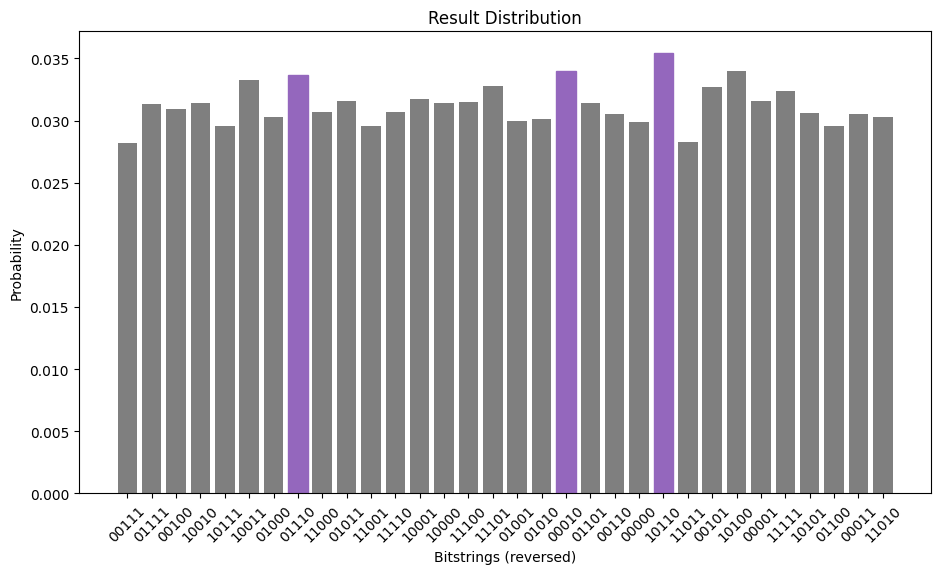

In [35]:
plt.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p[0])].set_color("tab:purple")
plt.show()